# This ia a notebook to understand Optimal transport pathways on SO3 space

there are many other manifolds to explore; look up geoopt packages

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

# Initialize SO(3) geometry
so3 = SpecialOrthogonal(n=3)

In [3]:
# generate two random distributions of rotations
def sample_so3(num_samples):
    """Generate random samples from SO(3)."""
    return so3.random_uniform(n_samples=num_samples)

num_samples = 20
rotations_source = sample_so3(num_samples)  # Source distribution
rotations_target = sample_so3(num_samples)  # Target distribution

print(rotations_source.shape)

(20, 3, 3)


In [4]:
# compute the pairwise geodesic distances between the two distributions(cost matrix)
def geodesic_distance_matrix(rotations1, rotations2, metric):
    """
    Compute the pairwise geodesic distance between two sets of rotations.
    
    Parameters:
    - rotations1: Array of rotation matrices from the first distribution.
    - rotations2: Array of rotation matrices from the second distribution.
    - metric: The Riemannian metric associated with the manifold.
    
    Returns:
    - cost_matrix: Pairwise geodesic distance matrix.
    """
    n1 = len(rotations1)
    n2 = len(rotations2)
    cost_matrix = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            cost_matrix[i, j] = metric.dist(rotations1[i], rotations2[j])
    return cost_matrix

# Compute the geodesic distance cost matrix
cost_matrix = geodesic_distance_matrix(rotations_source, rotations_target, so3.metric)



In [5]:
#
from scipy.spatial.transform import Rotation

print("Cost matrix:")
print(cost_matrix[0][0])
# to undestand this cost matrix value
rotation_diff=rotations_source[0].T @ rotations_target[0]

#rotation_diff=rotation.Rotation.from_matrix(rotation_diff)
rotation_vector =Rotation.from_matrix(rotation_diff).as_rotvec()
rotation_angle = np.linalg.norm(rotation_vector)
print("rotation_diff", rotation_angle)


Cost matrix:
2.738997985832617
rotation_diff 2.7389979858326203


In [6]:
# optimal transport using the Sinkhorn-Knopp algorithm with emtropy regularization
def sinkhorn_knopp(a, b, cost_matrix, reg=0.01, num_iters=100):
    """Solve OT using Sinkhorn algorithm."""
    K = np.exp(-cost_matrix / reg)
    u = np.ones_like(a)
    v = np.ones_like(b)
    
    for _ in range(num_iters):
        u = a / (K @ v)
        v = b / (K.T @ u)
    
    transport_plan = np.diag(u) @ K @ np.diag(v)
    return transport_plan

# Uniform distributions
a = np.ones(num_samples) / num_samples
b = np.ones(num_samples) / num_samples

transport_plan = sinkhorn_knopp(a, b, cost_matrix)



In [12]:
print("Optimal Transport Plan:")
print(transport_plan)

Optimal Transport Plan:
[[1.72498699e-022 8.46480712e-071 5.42182709e-068 4.12144927e-069
  3.96331242e-059 2.95970588e-034 3.07725254e-002 1.15347710e-041
  1.30754003e-037 9.25360717e-029 1.93264555e-002 9.50460233e-046
  6.21923431e-061 2.11527865e-005 1.62780641e-011 1.14726689e-008
  2.17022464e-073 1.91921406e-057 1.61341003e-063 5.67207169e-041]
 [1.10419119e-009 2.58050779e-014 1.16605811e-062 5.30995915e-003
  1.28133367e-027 3.59386082e-043 1.59854677e-002 2.13614428e-006
  4.71169196e-034 1.05446800e-026 2.36098741e-002 5.03834313e-003
  5.51069928e-021 1.02896976e-014 1.05600057e-054 4.10197382e-029
  1.31445066e-018 1.11448494e-013 1.89054691e-011 1.94988388e-018]
 [2.16699028e-004 1.61798732e-105 3.69450534e-003 6.00373051e-068
  6.29026087e-039 2.44223095e-032 6.20511135e-039 7.04125122e-008
  4.61184661e-002 1.02256479e-004 6.93884923e-018 1.52832369e-063
  9.47612571e-030 3.03976621e-075 1.06844722e-056 9.55708735e-062
  1.67646004e-062 1.06421213e-021 1.46324140e-083 

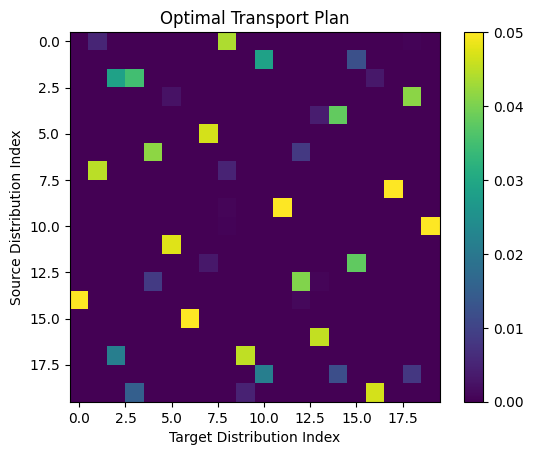

In [7]:
#visualize the transport plan
import matplotlib.pyplot as plt

plt.imshow(transport_plan, cmap="viridis")
plt.colorbar()
plt.title("Optimal Transport Plan")
plt.xlabel("Target Distribution Index")
plt.ylabel("Source Distribution Index")
plt.show()


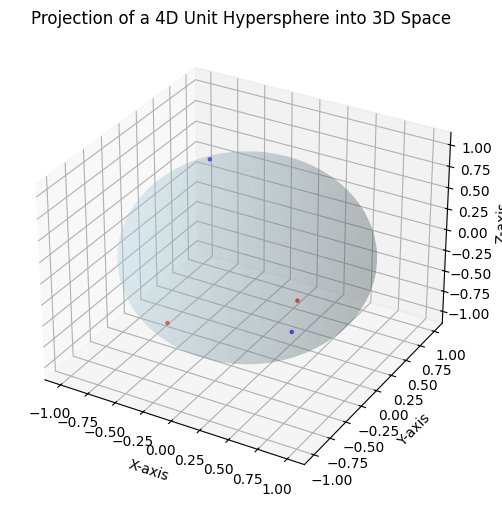

In [11]:
# visualize the source and target distributions on SO3
import torch

def visualize_sphere_extrinsic(r1, r2):


  # Normalize each point to lie on the unit hypersphere
  #r_projected =  r/ r.norm(dim=1, keepdim=True)

  # Convert tensors to numpy arrays for plotting
  r1_np = r1.numpy()
  r2_np = r2.numpy()

  # covert matrix to rotation vector
  r1_np = Rotation.from_matrix(r1_np).as_rotvec()
  r2_np = Rotation.from_matrix(r2_np).as_rotvec()
  # Normalize the rotation vectors    
  r1_np = r1_np / np.linalg.norm(r1_np, axis=1, keepdims=True)
  r2_np = r2_np / np.linalg.norm(r2_np, axis=1, keepdims=True)


  # Set up the 3D plot
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')

  # Plot the projected points
  ax.scatter(r1_np[:, 0], r1_np[:, 1], r1_np[:, 2], s=5, alpha=0.7,c='r')
  ax.scatter(r2_np[:, 0], r2_np[:, 1], r2_np[:, 2], s=5, alpha=0.7,c='b')

# Plot the sphere
  u = np.linspace(0, 2 * np.pi, 100)
  v = np.linspace(0, np.pi, 100)
  x = np.outer(np.cos(u), np.sin(v))
  y = np.outer(np.sin(u), np.sin(v))
  z = np.outer(np.ones(np.size(u)), np.cos(v))
  ax.plot_surface(x, y, z, color="lightblue", alpha=0.2)

  # Label the axes
  ax.set_xlabel('X-axis')
  ax.set_ylabel('Y-axis')
  ax.set_zlabel('Z-axis')
  ax.set_title('Projection of a 4D Unit Hypersphere into 3D Space')

  # Show the plot
  plt.show()

visualize_sphere_extrinsic(torch.tensor(rotations_source[:2]),torch.tensor(rotations_target[:2]))


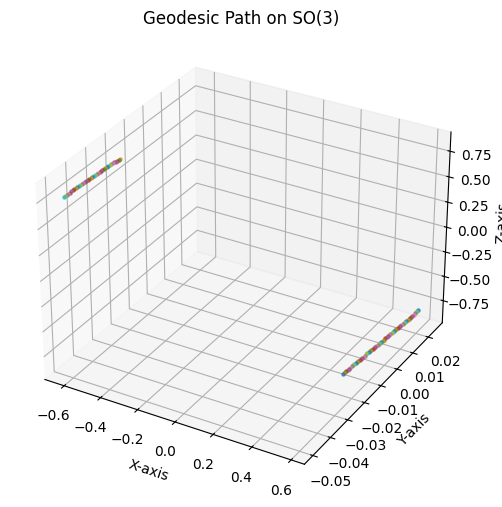

In [17]:
# visualize the transport path
# take scoure 10 target 4 as example (based on the transport plan, they are paired)
source_index = 10  
target_index = 19
source_rotation = rotations_source[source_index]
target_rotation = rotations_target[target_index]    
# Compute the geodesic path

def interpolate_rotations(rot1, rot2, t):
    """Geodesic interpolation between two rotations."""
    return so3.exp(t * so3.log(rot2, rot1), rot1)

def geodesic_path(source_rotation, target_rotation, num_points=100):
    """Compute the geodesic path between two rotations."""
    path = []
    for t in np.linspace(0, 1, num_points):
        rotation = interpolate_rotations(source_rotation, target_rotation, t)
        # Convert rotation matrix to rotation vector
        rotation_vector = Rotation.from_matrix(rotation).as_rotvec()
        # Normalize the rotation vector
        rotation_vector = rotation_vector / np.linalg.norm(rotation_vector)
        path.append(rotation_vector)
    return np.array(path)
# Compute the geodesic path
path = geodesic_path(source_rotation, target_rotation)
# Visualize the geodesic path       
def visualize_geodesic_path(path):
    """Visualize the geodesic path on SO(3)."""
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract the rotation matrices
    for rotation in path:
        ax.scatter(rotation[0], rotation[1], rotation[2], s=5, alpha=0.7)
    
    # Label the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('Geodesic Path on SO(3)')
    
    # Show the plot
    plt.show()
visualize_geodesic_path(path)

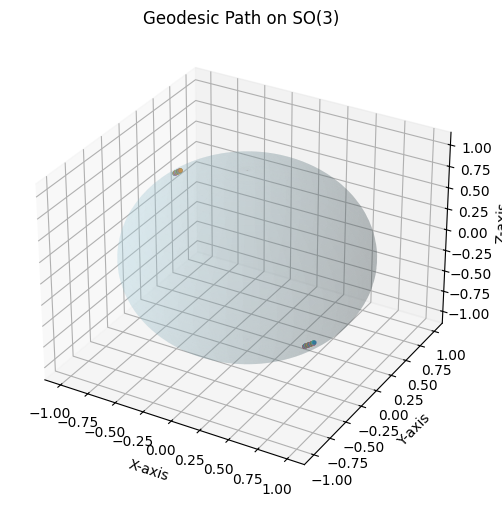

In [24]:
# visulaize the transport plan on so3 
def visualize_geodesic_path_on_so3(path, r1, r2):
    """Visualize the geodesic path on SO(3)."""
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')


    # Convert tensors to numpy arrays for plotting
    r1_np = r1.numpy()
    r2_np = r2.numpy()

        # covert matrix to rotation vector
    r1_np = Rotation.from_matrix(r1_np).as_rotvec()
    r2_np = Rotation.from_matrix(r2_np).as_rotvec()
    # Normalize the rotation vectors    
    r1_np = r1_np / np.linalg.norm(r1_np, axis=1, keepdims=True)
    r2_np = r2_np / np.linalg.norm(r2_np, axis=1, keepdims=True)


    # Plot the projected points
    ax.scatter(r1_np[:, 0], r1_np[:, 1], r1_np[:, 2], s=5, alpha=0.7,c='r',marker='*')
    ax.scatter(r2_np[:, 0], r2_np[:, 1], r2_np[:, 2], s=5, alpha=0.7,c='b',marker='*')

    # Plot the sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color="lightblue", alpha=0.2)
    

    
    # Extract the rotation matrices
    for rotation in path:
        ax.scatter(rotation[0], rotation[1], rotation[2], s=5, alpha=0.7)
        #ax.scatter(rotation[1, 0], rotation[1, 1], rotation[1, 2], s=5, alpha=0.7,c='k')
    
    # Label the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('Geodesic Path on SO(3)')
    
    # Show the plot
    plt.show()
visualize_geodesic_path_on_so3(path, torch.tensor(rotations_source[10:11]),torch.tensor(rotations_target[19:20]))
